# CNN for time series analysis

In [17]:
%pip install tensorflow==2.15

  Using cached tensorflow-2.15.0-cp311-cp311-macosx_12_0_arm64.whl.metadata (3.6 kB)
  Using cached tensorflow_macos-2.15.0-cp311-cp311-macosx_12_0_arm64.whl.metadata (4.2 kB)
  Using cached ml_dtypes-0.2.0-cp311-cp311-macosx_10_9_universal2.whl.metadata (20 kB)
  Using cached numpy-1.26.4-cp311-cp311-macosx_11_0_arm64.whl.metadata (114 kB)
  Using cached wrapt-1.14.1-cp311-cp311-macosx_11_0_arm64.whl.metadata (6.7 kB)
  Using cached tensorboard-2.15.2-py3-none-any.whl.metadata (1.7 kB)
  Using cached tensorflow_estimator-2.15.0-py2.py3-none-any.whl.metadata (1.3 kB)
  Using cached keras-2.15.0-py3-none-any.whl.metadata (2.4 kB)
  Using cached google_auth_oauthlib-1.2.2-py3-none-any.whl.metadata (2.7 kB)
  Using cached cachetools-5.5.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached pyasn1_modules-0.4.2-py3-none-any.whl.metadata (3.5 kB)
  Using cached rsa-4.9.1-py3-none-any.whl.metadata (5.6 kB)
  Using cached requests_oauthlib-2.0.0-py2.py3-none-any.whl.metadata (11 kB)
  Using cac

In [4]:
import sys
import os
sys.path.append(os.path.abspath("..")) 

import numpy as np
import pandas as pd
import plotly_express as px
from datetime import datetime 
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from functions_laura.Data_processing import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from tensorflow.keras.models import load_model


![CNN](CNN-wibawa_JBD_2022.png)

### Data normalization

Data normalization is essential for CNN because it can scale the attribute into a specific range required by the activation function. This study uses Min–Max normalization.

## Exponential smoothing with optimum $\alpha$

The smoothed data $ {S}_{t} $ is the result of smoothing the raw data $ {\{X}_{t}\} $. The smoothing factor, $\alpha$ is a value that determines the level of smoothing. The range of $\alpha$ is between 0 and 1 (0 ≤ alpha ≤ 1). When $\alpha$ close to 1, the learning process is fast because it has a less smoothing effect. In contrast, values of $\alpha$ closer to 0 have a more significant smoothing effect and are less responsive to recent changes (slow learning).

How to determine optimum $\alpha$:

$$ Optimum \alpha ={ \alpha }_{max}- \frac{\frac{1}{n} \sum_{t=1}^{n}{ X}_{t}}{{ X}_{ max}- { X}_{ min}} $$


This is the optimum smoothing:

$$ {S}_{t}={ S}_{t-1} +\frac{\left({ X}_{ max}- { X}_{ min}\right)-\frac{1}{n}\sum_{t=1}^{n}{ X}_{t}}{{{X}_{ max}- X}_{ min}}({ X}_{t}-{ S}_{t-1}) $$

## CNN with lucas hidden layers

The input layer used one feature since it is a univariate model. Flatten was used for input to get a fully connected layer. The fully connected layer contains dense for the number of hidden layers.

Instead of using a random number, we used the Lucas number to determine the hidden layer. The Lucas number (Ln) is recursive in the same way as the Fibonacci sequence (Fn), with each term equal to the sum of the two preceding terms, yet with different initial values. This sequence was selected since it provides a golden ratio number. The golden ratio emerges in nature, demonstrating that this enchanted number is ideal for determining the optimal solution to numerous covering problems such as arts, engineering, and financial forecasting. In this study, the Lucas number starts from three and ends with the last number before 100, which is 76. We limited the number of hidden layers to avoid the impact of time consumption and efficiency performance. Overall, we used 3, 4, 7, 11, 18, 29, 47, and 76 [40] for the numbers of hidden layers.

![hidden](Lucas-hidden.png)



loading of the data and creating the needed data from the dataframe

In [5]:
from functions_laura.Data_processing import resample_with_seasonality
from functions_laura.Data_processing import resample
from functions_laura.Data_processing import add_seasonal

In [ ]:
df = pd.read_parquet('../data/hamburg_23-25-brands.parquet')


resample the data

In [7]:
# only compute the seasonality on the training data!
resampled_df = resample(df)

train-test split

In [8]:
train_df, test_df = train_test_split(resampled_df)

In [39]:
test_df.columns

Index(['datetime', 'e5'], dtype='object')

In [9]:
train_df_seasonal = add_seasonal(train_df)

In [66]:
train_df_seasonal.info()

<class 'pandas.core.frame.DataFrame'>
Index: 244800 entries, 1 to 244800
Data columns (total 3 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   datetime            244800 non-null  datetime64[ns]
 1   seasonal_component  244799 non-null  float64       
 2   e5                  244800 non-null  float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 7.5 MB


Add the training seasonality to the test set

In [42]:
# Debug: Check DataFrame structure and datetime column
print("Columns in test_df:", test_df.columns.tolist())
print("\nDatetime column info:", test_df['datetime'].dtype)
print("\nFirst few rows of datetime:", test_df['datetime'].head())
print("\nFirst few rows of seasonal_patterns:", seasonal_patterns.head())
print("\nSeasonal patterns datetime info:", seasonal_patterns.index.dtype)

Columns in test_df: ['datetime', 'e5']

Datetime column info: datetime64[ns]

First few rows of datetime: 211680   2025-01-05 00:00:00
211681   2025-01-05 00:05:00
211682   2025-01-05 00:10:00
211683   2025-01-05 00:15:00
211684   2025-01-05 00:20:00
Name: datetime, dtype: datetime64[ns]

First few rows of seasonal_patterns: 1   -0.005900
2   -0.005899
3   -0.005897
4   -0.005893
5   -0.005885
Name: seasonal_component, dtype: float64

Seasonal patterns datetime info: int64


In [44]:
# 2. Get the seasonal patterns from training data
seasonal_patterns = train_df_seasonal[['seasonal_component', 'datetime']]

In [47]:
print("Test DataFrame datetime info:")
test_df.info()
print("\nSeasonal patterns info:")
seasonal_patterns.info()

Test DataFrame datetime info:
<class 'pandas.core.frame.DataFrame'>
Index: 40033 entries, 211680 to 251712
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   datetime  40033 non-null  datetime64[ns]
 1   e5        40033 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 938.3 KB

Seasonal patterns info:
<class 'pandas.core.frame.DataFrame'>
Index: 244800 entries, 1 to 244800
Data columns (total 2 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   seasonal_component  244799 non-null  float64       
 1   datetime            244800 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(1)
memory usage: 5.6 MB


In [51]:
# Take first 288 values (one complete cycle) and repeat
seasonal_pattern = train_df_seasonal['seasonal_component'].iloc[:288].values
test_df['seasonal_component'] = np.tile(seasonal_pattern, len(test_df)//288 + 1)[:len(test_df)]

# Verify no NaNs
print(test_df.isna().sum())

datetime              0
e5                    0
seasonal_component    0
dtype: int64


* training data = train_df_seasonal
* testing data = test_df

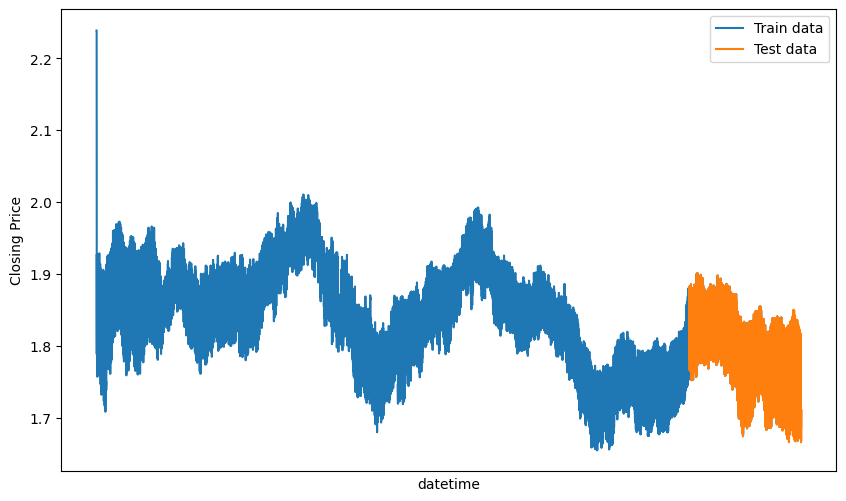

In [65]:
# Plotting the train and test set
plt.figure(figsize=(10,6))
plt.xlabel('datetime')
plt.ylabel('Closing Price')
plt.xticks([])
plt.plot(train_df_seasonal['e5'], label='Train data')
plt.plot(test_df['e5'], label='Test data')
plt.legend();

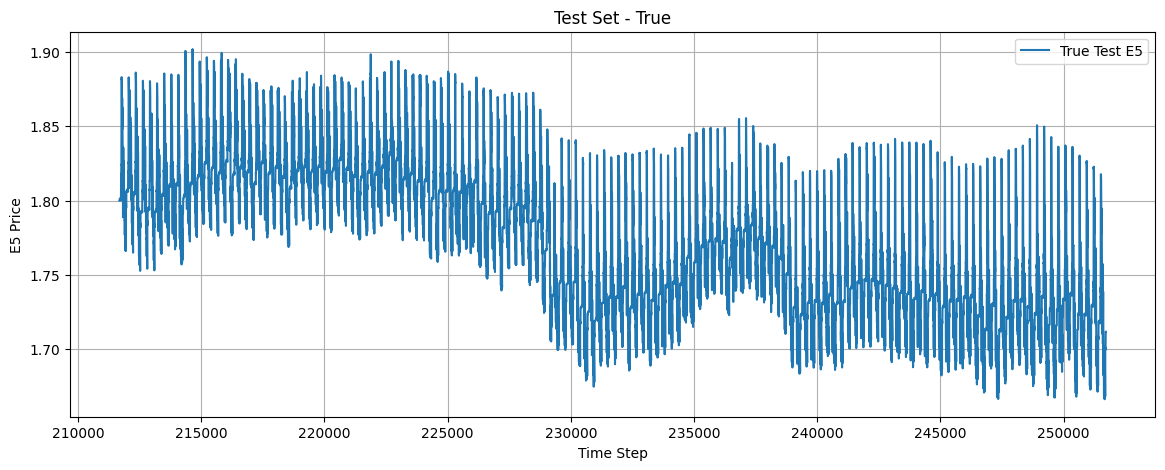

In [10]:
# Plot Test
plt.figure(figsize=(14, 5))
plt.plot(test_df['e5'], label='True Test E5')
plt.title("Test Set - True")
plt.xlabel("Time Step")
plt.ylabel("E5 Price")
plt.legend()
plt.grid(True)
plt.show()

we scale the data

In [11]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(train_df_seasonal[['e5', 'seasonal_component']])

In [53]:
scaled_test = scaler.fit_transform(test_df[['e5', 'seasonal_component']])

In [13]:
scaled_data[:5]

array([[1.        , 0.38379771],
       [1.        , 0.38379937],
       [1.        , 0.38381995],
       [1.        , 0.38386933],
       [1.        , 0.38395035]])

In [14]:
scaled_test[:5]

array([[0.56747671],
       [0.56747671],
       [0.56747671],
       [0.56747671],
       [0.56747671]])

### Transforming the data...
so it can fit into my model. We are using a sliding window of 288 (1 day). After every 288 e5 prices, we look at the price that comes after it. 
$X$ is an array consisting of all the sequences, so it has 288 columns.
$y$ is a 1D array of all these values that come after the 288 (= the next step)

$X$ and $y$ have 288 less rows than the original df, because:

| i    | Input `X[i]` (rows used) | Target `y[i]` |
| ---- | ------------------------ | ------------- |
| 0    | rows 0 to 287            | row 288, E5   |
| 1    | rows 1 to 288            | row 289, E5   |
| 2    | rows 2 to 289            | row 290, E5   |
| ...  | ...                      | ...           |
| 9711 | rows 9711 to 9998        | row 9999, E5  |


In [67]:
def create_sequences(data, window_size, target_col_index):
    """Create sequences for time series prediction.
    
    Args:
        data: Scaled input data with shape (samples, features)
        window_size: Number of time steps to look back
        target_col_index: Index of the target column to predict
        
    Returns:
        X: Input sequences with shape (samples, window_size, features)
        y: Target values with shape (samples,)
    """
    X = []
    y = []
    for i in range(len(data) - window_size):
        # Get sequence of all features
        sequence = data[i:(i + window_size)]
        X.append(sequence)
        # Get next value of target feature
        target = data[i + window_size, target_col_index]
        y.append(target)
    return np.array(X), np.array(y)

# Create sequences with e5 as target (index 0)
window_size = 288  # one day of 5-min steps
target_col_index = 0  # e5 price is in first column
X, y = create_sequences(scaled_data, window_size, target_col_index)

# Print shapes to verify
print(f"Input shape: {X.shape}")  # Should be (samples, 288, 2)
print(f"Target shape: {y.shape}") # Should be (samples,)

Input shape: (244512, 288, 2)
Target shape: (244512,)


In [68]:
print(X.shape)

(244512, 288, 2)


In [69]:
X[:5]

array([[[1.        , 0.38379771],
        [1.        , 0.38379937],
        [1.        , 0.38381995],
        ...,
        [0.25656593, 0.38226861],
        [0.25656593, 0.38237217],
        [0.26117539, 0.38373264]],

       [[1.        , 0.38379937],
        [1.        , 0.38381995],
        [1.        , 0.38386933],
        ...,
        [0.25656593, 0.38237217],
        [0.26117539, 0.38373264],
        [0.26117539, 0.38379771]],

       [[1.        , 0.38381995],
        [1.        , 0.38386933],
        [1.        , 0.38395035],
        ...,
        [0.26117539, 0.38373264],
        [0.26117539, 0.38379771],
        [0.26117539, 0.38379937]],

       [[1.        , 0.38386933],
        [1.        , 0.38395035],
        [1.        , 0.38425527],
        ...,
        [0.26117539, 0.38379771],
        [0.26117539, 0.38379937],
        [0.26117539, 0.38381995]],

       [[1.        , 0.38395035],
        [1.        , 0.38425527],
        [1.        , 0.38430671],
        ...,
        [

In [70]:
y.shape

(244512,)

In [71]:
y[:5]

array([0.26117539, 0.26117539, 0.26117539, 0.26117539, 0.26117539])

In [72]:
# we create x_test and y_test from our scaled_test data
window_size = 288  # one day of 5-min steps
target_col_index = 0  # assuming e5 is in column 1 of your scaled array

X_test, y_test = create_sequences(scaled_test, window_size, target_col_index)

In [73]:
scaled_test.shape

(40033, 2)

In [74]:
y_test.shape

(39745,)

In [75]:

# Example multivariate time-series data
# Assume 'data' is a NumPy array of shape (samples, timesteps, features)
# For instance, data.shape = (1000, 30, 5) for 1000 samples, 30 timesteps, and 5 features

# Define the model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(288, 2))) # 1-dimensional deconvolution
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(1))  # Output layer for forecasting

model.compile(optimizer='adam', loss='mse')

# Fit the model
# Assume 'X_train' and 'y_train' are your training data and labels
# model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1)

In [ ]:
model.fit(X, y, epochs=30, batch_size=32)

save the model

In [ ]:
timestamp = datetime.now().strftime("%Y%m%d_%H%M")
#model.save(f"fuel_price_cnn_model_{timestamp}.h5")
model.save(f"fuel_price_cnn_model_{timestamp}")

INFO:tensorflow:Assets written to: fuel_price_cnn_model_20250606_2016/assets


INFO:tensorflow:Assets written to: fuel_price_cnn_model_20250606_2016/assets


predictions

In [ ]:
#model = load_model('fuel_price_cnn_model_20250606_1810') # this one has data leakage
model = load_model('uel_price_cnn_model_20250606_2016')


In [ ]:
y_pred_train = model.predict(X)
y_pred_test = model.predict(X_test)

1243/1243 [==============================] - 1s 1ms/step


In [ ]:
print(y_pred_train.shape)
print(y_pred_test.shape)

(244512, 1)
(39745, 1)


In [ ]:
y_pred_train[:5]

array([[0.26006842],
       [0.25710043],
       [0.2560199 ],
       [0.2596372 ],
       [0.2626724 ]], dtype=float32)

In [ ]:
def inverse_scale(preds, original_data, target_index, scaler):
    """Rebuild array with target predictions placed at correct column index."""
    dummy = np.zeros((len(preds), original_data.shape[1]))
    dummy[:, target_index] = preds.flatten()
    return scaler.inverse_transform(dummy)[:, target_index]

# Inverse scaling
y_inv = inverse_scale(y.reshape(-1, 1), scaled_data, 0, scaler)
y_pred_train_inv = inverse_scale(y_pred_train, scaled_data, 0, scaler)

y_test_inv = inverse_scale(y_test.reshape(-1, 1), scaled_test, 0, scaler)
y_pred_test_inv = inverse_scale(y_pred_test, scaled_test, 0, scaler)

In [ ]:
# Get the aligned datetime values - only remove window_size from the start
dt_aligned = test_df['datetime'][window_size:]  # Only offset by window_size at start

# Create DataFrame with matching lengths
# It has a datetime column and the e5 column
y_pred_test_df = pd.DataFrame({
    'datetime': dt_aligned[:len(y_pred_test_inv)],  # Slice to match prediction length
    'e5': y_pred_test_inv
})

# Verify lengths match
print(f"datetime length: {len(dt_aligned[:len(y_pred_test_inv)])}")
print(f"predictions length: {len(y_pred_test_inv)}")

datetime length: 39745
predictions length: 39745


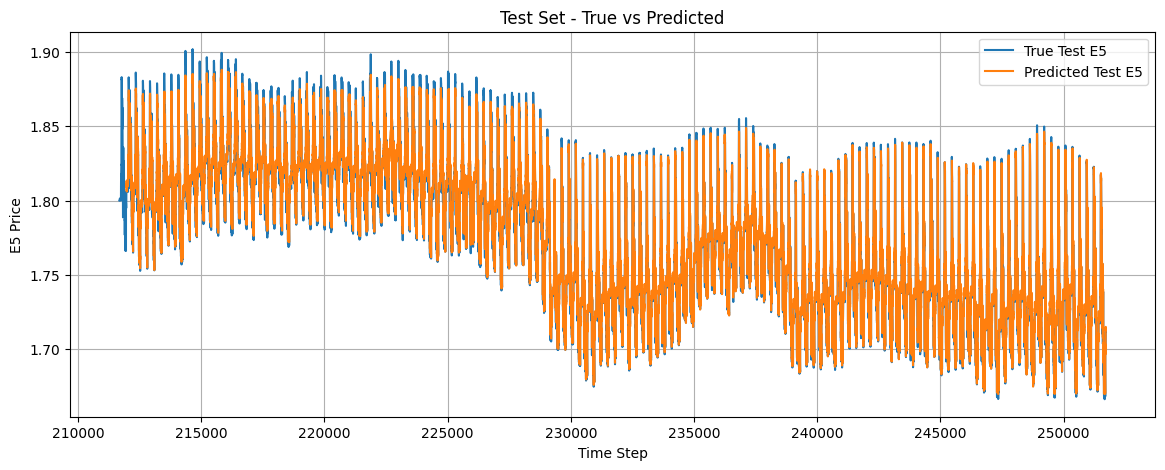

In [ ]:
import matplotlib.pyplot as plt

# Plot Test
plt.figure(figsize=(14, 5))
plt.plot(test_df['e5'], label='True Test E5')
plt.plot(y_pred_test_df['e5'], label='Predicted Test E5')
plt.title("Test Set - True vs Predicted")
plt.xlabel("Time Step")
plt.ylabel("E5 Price")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:

# Combine true and predicted values into one DataFrame for plotting
plot_df = pd.DataFrame({
    "datetime": test_df['datetime'],
    "True Test E5": test_df['e5'],
    "Predicted Test E5": y_pred_test_df['e5']
})

# Melt the DataFrame to long format for px.line
plot_df_melted = plot_df.melt(id_vars="datetime", 
                              value_vars=["True Test E5", "Predicted Test E5"], 
                              var_name="Type", 
                              value_name="E5 Price")

# Create interactive line plot
fig = px.line(plot_df_melted, 
              x="datetime", 
              y="E5 Price", 
              color="Type", 
              title="Test Set - True vs Predicted")

fig.update_layout(
    width=1800,
    height=800,
    xaxis_title="Datetime",
    yaxis_title="E5 Price"
)

fig.show()


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

# Train error
mae_train = mean_absolute_error(y_inv, y_pred_train_inv)
mape_train = mean_absolute_percentage_error(y_inv, y_pred_train_inv)

# Test error
mae_test = mean_absolute_error(y_test_inv, y_pred_test_inv)
mape_test = mean_absolute_percentage_error(y_test_inv, y_pred_test_inv)

print(f"Train MAE: {mae_train:.4f}, Train MAPE: {mape_train*100:.2f}%")
print(f"Test MAE: {mae_test:.4f}, Test MAPE: {mape_test*100:.2f}%")


Train MAE: 0.0005, Train MAPE: 0.03%
Test MAE: 0.0034, Test MAPE: 0.19%
